### Slider control of `KIMlab-Dualarms`

In [5]:
import mujoco
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../utils')
from mujoco_parser import MuJoCoParserClass
from util import MultiSliderClass
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[3.1.1]


### Parse `scene_dualarms.xml`

In [6]:
xml_path = '../asset/kimlab_dualarms/scene_dualarms.xml'
env = MuJoCoParserClass(name='Dual Arms',rel_xml_path=xml_path,VERBOSE=True)
# Modify the color of body exluding 'world'
for body_name in env.body_names:
    if body_name in ['world']: continue
    for geom_idx in env.get_geom_idxs_from_body_name(body_name=body_name):
        env.model.geom(geom_idx).rgba = [0.3,0.3,0.5,0.5]
print ("Done.")

dt:[0.0020] HZ:[500]
n_dof (=nv):[32]
n_geom:[55]
geom_names:[None, None, None, None, None, None, 'floor', None, None, None, None, None, None, None, None, None, None, None, None, 'robot1/wrist_mesh', 'robot1/palm_mesh', 'robot1/index_mesh_1', 'robot1/index_mesh_2', 'robot1/middle_mesh_1', 'robot1/middle_mesh_2', 'robot1/ring_mesh_1', 'robot1/ring_mesh_2', 'robot1/pinky_mesh_1', 'robot1/pinky_mesh_2', 'robot1/thumb_mesh_1', 'robot1/thumb_mesh_2', None, None, None, None, None, None, None, None, None, None, None, None, 'robot2/wrist_mesh', 'robot2/palm_mesh', 'robot2/index_mesh_1', 'robot2/index_mesh_2', 'robot2/middle_mesh_1', 'robot2/middle_mesh_2', 'robot2/ring_mesh_1', 'robot2/ring_mesh_2', 'robot2/pinky_mesh_1', 'robot2/pinky_mesh_2', 'robot2/thumb_mesh_1', 'robot2/thumb_mesh_2']
n_body:[43]
body_names:['world', 'robot1/link2', 'robot1/link3', 'robot1/link4', 'robot1/link5', 'robot1/link6', 'robot1/end_link', 'robot1/index_L1', 'robot1/index_L2', 'robot1/index_tip', 'robot1/middle_L1

### Slider Control

Pressed ESC
Quitting.


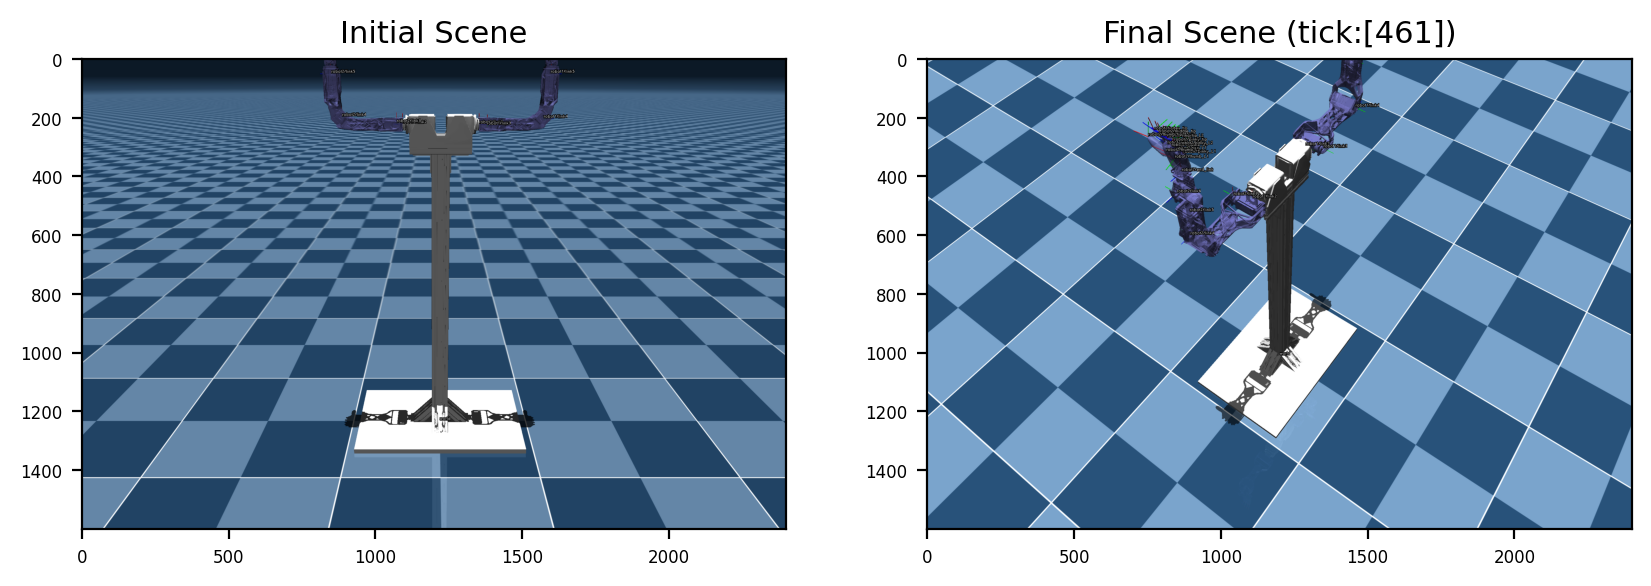

In [7]:
# Initialize sliders for joint control with coupling
ctrl_joint_names = env.joint_names
idxs_fwd = env.get_idxs_fwd(joint_names=ctrl_joint_names)
q_ctrl = env.get_qpos_joints(ctrl_joint_names)
n_ctrl_joint = len(ctrl_joint_names)

sliders = MultiSliderClass(
    n_slider      = n_ctrl_joint,
    title         = 'Sliders for Common-Rig Control',
    window_width  = 530,
    window_height = 800,
    x_offset      = 300,
    y_offset      = 100,
    slider_width  = 350,
    label_texts   = ctrl_joint_names,
    slider_mins   = env.joint_ranges[:,0],
    slider_maxs   = env.joint_ranges[:,1],
    slider_vals   = q_ctrl,
    resolution    = 0.01,
    VERBOSE       = False
)
for _ in range(100): sliders.update() # to avoid GIL-related error

# Initialize MuJoCo viewer
env.init_viewer(viewer_title='Dual Arms',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=180,distance=3.0,elevation=-21,lookat=[0.02,-0.03,0.8])
# Reset and loop
env.reset()
FIRST_FLAG = True

while env.is_viewer_alive() and sliders.is_window_exists():
    # Simulate
    sliders.update() # update slider control
    q_fwd = sliders.get_slider_values()

    env.data.qpos[idxs_fwd] = q_fwd
    env.forward(q=env.data.qpos,INCREASE_TICK=True)
    
    if env.loop_every(tick_every=10):
        # Plot world frame
        # env.plot_T(p=np.zeros(3),R=np.eye(3,3),
        #            PLOT_AXIS=True,axis_len=0.5,axis_width=0.005)
        
        # # Text information
        # env.plot_T(p=np.array([0,0,0.5]),R=np.eye(3),PLOT_AXIS=False,
        #            label='Tick:[%d]'%(env.tick))
        
        # Plot bodies
        for body_name in env.body_names:
            p,R = env.get_pR_body(body_name=body_name)
            env.plot_T(p=p,R=R,PLOT_AXIS=True,axis_len=0.05,axis_width=0.001,label=body_name)
        
        # Plot revolute joints with arrow
        for rev_joint_idx,rev_joint_name in zip(env.rev_joint_idxs,env.rev_joint_names):
            axis_joint = env.model.jnt_axis[rev_joint_idx]
            p_joint,R_joint = env.get_pR_joint(joint_name=rev_joint_name)
            axis_world = R_joint@axis_joint
            axis_rgba = np.append(np.eye(3)[:,np.argmax(axis_joint)],0.2)
            axis_len,axis_r = 0.02,0.002
            env.plot_arrow_fr2to(
                p_fr=p_joint,p_to=p_joint+axis_len*axis_world,
                r=axis_r,rgba=axis_rgba)
        # Plot contact information
        # env.plot_contact_info(h_arrow=0.3,rgba_arrow=[1,0,0,1],
        #                       PRINT_CONTACT_BODY=True)
        env.render()
        
    # Save image
    if env.is_viewer_alive() and FIRST_FLAG:
        scene_img_init = env.grab_image()
    if env.is_viewer_alive() and env.loop_every(tick_every=100):
        scene_img_final = env.grab_image()
    FIRST_FLAG = False
        
# Close MuJoCo viewer and sliders
env.close_viewer()
sliders.close()

# Plot initial and final scenes
fig,axs = plt.subplots(1,2,figsize=(10,4))
plt.subplots_adjust(top=0.85,bottom=0.15,wspace=0.2,hspace=0.5)
axs[0].imshow(scene_img_init)
axs[0].set_title('Initial Scene',fontsize=11)
axs[1].imshow(scene_img_final)
axs[1].set_title('Final Scene (tick:[%d])'%(env.tick),fontsize=11)
plt.show()